+++
notebook = true
title = "Wellbore Heat Transport - EUBHE"
date = "2023-08-03"
author = "Chaofan Chen, Haibing Shao, Frieder Loer"
image = "figures/pipe_flow_3d_model.png"
web_subsection = "heat-transport-bhe"
project = ["Parabolic/T/BHE_1P/BHE_1P.prj"]
+++


<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./pipe_flow_ebhe.ipynb" download="pipe_flow_ebhe.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=pipe_flow_ebhe.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Parabolic/T/BHE_1P/pipe_flow_ebhe.py"><img src="https://img.shields.io/static/v1?label=Source:&message=pipe_flow_ebhe.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/6.5.6-0.7.0?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/Parabolic/T/BHE_1P/pipe_flow_ebhe.py%26branch=6.5.6%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

## Problem description

Ramey et al. (1962) proposed the analytical solution concerning the wellbore heat transmission, which can be used to quantify the fluid temperature change in the wellbore.
In order to verify the single pipe flow model in the OGS, the numerical results were compared with Ramey's analytical solution Ramey et al. (1962).
The detailed calculation of the Ramey's analytical solution is given below.
A detailed analysis of an enhanced U-tube borehole heat exchanger (EUBHE) can be found in Chen, C. et al. (2021).

## Model Setup

In this benchmark, the length of the wellbore is 30 m as shown in Figure 1 and the cold water is injected into the inlet point of the wellbore with the constant temperature of 20°C.
The initial temperature of the fluid and grout in the wellbore is 20 $^{\circ}$C, and temperature of the surrounding rock is 55 $^{\circ}$C.
The wellbore and pipe diameter are 0.28 m and 0.25826 m, respectively.
And the flow rate is 0.0002 $m^3/s$.

![Single pipe flow model](./figures/pipe_flow_3d_model.png)

Figure 1: Single pipe flow model

In [1]:
# Import required libraries

import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot
import pandas as pd

## Ramey's analytical solution

The equations are followed by their implementation in python.

In [2]:
# Define constants

T_d = 55  # Temperature of undistributed formation
T_i = 20  # Temperature of inlet fluid
Z = np.insert(
    np.linspace(0.3, 30, 100), 0, 1e-10
)  # Depth below surface, start with very small value to prevent division by zero
q = 0.0002  # Flow rate of fluid in wellbore, m3/s
rho_f = 1000  # Density of fluid, unit kg/m3
c_p_f = 4190  # Specific heat capacity of fluid in wellbore
mu_f = 1.14e-3  # Unit kg/m/s;
lambda_f = 0.59  # Unit W/m/K
rho_re = 1800  # Density of geothermal reservoir
c_p_re = 1778  # Specific heat capacity of geothermal reservoir
lambda_re = 2.78018  # Heat conductivity coefficient of geothermal reservoir
lambda_g = 0.73  # Heat conductivity coefficient of grout and pipe
lambda_pi = 1.3
r_pi = 0.12913  # Inner radius of pipe and wellbore
r_b = 0.14
t_pi = 0.00587  # Thickness of the pipe
t = 86400 * 5  # Operation time

In Ramey's analytical solution Ramey et al. (1962), the outlet temperature of the pipe inside the wellbore can be calculated by

$$
    T_o(t) = T_{s} + (T_i(t) - T_{s})\exp(-\Delta z/X)
$$

In [3]:
def temp(T_d, T_i, delta_z, X):
    return T_d + (T_i - T_d) * np.exp(-delta_z / X)

The coefficient $X$ is determined by

$$
    X = \frac{q\rho_fc_{p,f}(\lambda_{s}+r_pUf(t))}{2\pi r_pU \lambda_{s}}
$$

where $q$ is the flow rate of the fluid in the wellbore.

In [4]:
def coefficient_x(q, rho_f, c_p_f, lambda_re, r_pi, U, f_t):
    return (
        (q * rho_f * c_p_f)
        * (lambda_re + r_pi * U * f_t)
        / (2 * np.pi * r_pi * U * lambda_re)
    )

With dimensionless time

$$
    t_D = \frac{\lambda_{s}t}{(\rho_{s}c_{p,s}r_b^{2})}
$$

In [5]:
def dimless_t(lambda_re, delta_t, rho_re, c_p_re, r_b):
    return lambda_re * delta_t / (rho_re * c_p_re * r_b * r_b)

the time function $f(t)$ can be calculated by

<!-- markdownlint-disable reference-links-images -->

$$
    f(t) = [0.4063+0.5\ln(t_D)][1+\frac{0.6}{t_D}], t_D > 1.5
$$

<!-- markdownlint-enable reference-links-images -->

$$
    f(t) = 1.1281\sqrt{t_D}(1-0.3\sqrt{t_D}), t_D \leqslant 1.5
$$

In [6]:
def time_function(t_D):
    if t_D > 1.5:
        f_t = (0.4063 + 0.5 * np.log(t_D)) * (1 + 0.6 / t_D)
    else:
        f_t = 1.1281 * np.sqrt(t_D) * (1 - 0.3 * np.sqrt(t_D))

    return f_t

The Prandtl and Reynolds number can be calculated as follows

$$
    \mathrm{Pr} = \frac{\mu_f c_{p,f}}{\lambda_f}
$$

$$
    \mathrm{Re} = \frac{\rho_f v d_{pi}}{\mu_f}
$$

where, $\mu_f, \rho_f$ and $\lambda_f$ is the fluid viscosity, density and thermal conductivity.

In [7]:
# Calculate the convective film resistance inside pipe
v = q / (np.pi * r_pi * r_pi)

# Reynolds number
Pr = mu_f * c_p_f / lambda_f
Re = rho_f * v * (2 * r_pi) / mu_f

The Nusselt number can be determined by the following equation Diersch, (2011):

$$
    \mathrm{Nu} = 4.364,\  \mathrm{Re} < 2300
$$

$$
    \mathrm{Nu} = \frac{(\xi_{k}/8)\  \mathrm{Re}_{k}\  \mathrm{Pr}}{1+12.7\sqrt{{\xi_k}/8}(\mathrm{Pr}^{2/3}-1)} [ 1+(\frac{{d_k}^{i}}{L})^{2/3}], Re \geq 10^4
$$

$$
    \mathrm{Nu} = (1-\gamma_{k})\  4.364 + \gamma_{k} ( \frac{(0.0308/8)10^{4}\mathrm{Pr}}{1+12.7\  \sqrt{0.0308/8}(\mathrm{Pr}^{2/3}-1)} \left[ 1+\left(\frac{d_{k}^{i}}{L}\right)^{2/3} \right] ), 2 300 \leq \mathrm{Re} < 10^{4}
$$

with

$$
    \xi_{k}=(1.8\  \log_{10}\mathrm{Re}_{k}-1.5)^{-2}
$$

and

$$
    \gamma_{k} = \frac{\mathrm{Re}_{k}-2300}{10^{4}-2300}
$$

In [8]:
# Estimate convective film coefficient
xi = (1.8 * np.log(Re) - 1.5) ** (-2)
Nu_l = (
    (xi / 8.0 * Re * Pr)
    / (1.0 + 12.7 * np.sqrt(xi / 8.0) * ((Pr) ** (2.0 / 3.0) - 1.0))
    * (1.0 + (r_pi / Z) ** (2.0 / 3.0))
)
Nu_lam = 4.364
gamma = (Re - 2300) / (10000 - 2300)

Nu_m = (1.0 - gamma) * 4.364 + gamma * (
    (0.0308 / 8.0 * 1.0e4 * Pr)
    / (1.0 + 12.7 * np.sqrt(0.0308 / 8.0) * ((Pr) ** (2.0 / 3.0) - 1.0))
    * (1.0 + (r_pi / Z) ** (2.0 / 3.0))
)

# Evaluate Nusselt number; based on the value of Re choose appropriate correlation
if Re < 2300:
    Nu_p = Nu_lam
elif Re > 10000:
    Nu_p = Nu_l
else:
    Nu_p = Nu_m

and the overall heat transfer coefficient $U$ is written as follows,

$$
    U = [\frac{r_{pi}+t_{pi}}{r_{pi}h}+(r_{pi}+t_{pi})(\frac{\ln{\frac{r_{pi}+t_{pi}}{r_{pi}}}}{\lambda_{pi}}+\frac{\ln{\frac{r_b}{r_{pi}+t_{pi}}}}{\lambda_{grout}})]^{-1}
$$

with

$$
    h = \frac{\lambda_f Nu}{2r_{pi}}
$$

In [9]:
h = lambda_f * Nu_p / (2 * r_pi)  # Unit: W/m2/K

U = 1 / (
    ((r_pi + t_pi) / (r_pi * h))
    + (r_pi + t_pi)
    * (
        np.log((r_pi + t_pi) / r_pi) / lambda_pi
        + np.log(r_b / (r_pi + t_pi)) / lambda_g
    )
)

The friction factor $f$, is evaluated by Churchill correlation Churchill et al. (1977),

$$
    f = \frac{1}{(\frac{1}{[((\frac{8}{Re})^{10}+(\frac{Re}{36500})^{20})]^{1/2}}+[2.21(\ln{\frac{Re}{7}})]^{10})^{1/5}}
$$

In [10]:
# Churchill correlation for friction factor
f = 1 / (
    (1 / (np.sqrt((8 / Re) ** 10 + (Re / 36500) ** 20))) + (2.21 * np.log(Re / 7)) ** 10
) ** (1 / 5)

With these equations the analytical solution can be computed:

In [11]:
# Compute solution

time_range = range(0, t + 1, 43200)

# Create a dataframe to store results for different z- and t-steps
row_names = Z
column_names = time_range


data = pd.DataFrame(index=row_names, columns=column_names)


for delta_z in Z:
    T_0 = []
    for delta_t in time_range:
        # Compute dimensionless time
        t_D = dimless_t(lambda_re, delta_t, rho_re, c_p_re, r_b)

        # Compute time function
        f_t = time_function(t_D)

        # Compute X
        X = coefficient_x(q, rho_f, c_p_f, lambda_re, r_pi, U, f_t)

        # Compute outlet temperature
        T_0.append(temp(T_d, T_i, delta_z, X))

    data.loc[delta_z] = T_0

## Numerical solution

In [12]:
# Create output path
out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
out_dir.mkdir(parents=True, exist_ok=True)

In [13]:
# Create an OGS-object
# Pass the project file and set an output file path
model = ot.Project(input_file="BHE_1P.prj", output_file=f"{out_dir}/BHE_1P.prj")

# set end time (in seconds) and the time increments
model.replace_text(
    5 * 24 * 60 * 60, xpath="./time_loop/processes/process/time_stepping/t_end"
)
model.replace_text(
    30, xpath="./time_loop/processes/process/time_stepping/timesteps/pair/repeat"
)
model.replace_text(
    4 * 60 * 60,
    xpath="./time_loop/processes/process/time_stepping/timesteps/pair/delta_t",
)
# Write to the output file
model.write_input()

# Run OGS
model.run_model(logfile=Path(out_dir) / "log.txt", args=f"-o {out_dir} -m .")

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/Parabolic/T/BHE_1P/pipe_flow_ebhe/BHE_1P.prj
Status: finished successfully.
Execution took 92.10091495513916 s


## Results and discussion

The outlet temperature change over time was compared against the analytical solution and presented in Figure 2.
After 30 days, the fluid temperature distribution in the wellbore is shown in Figure 3.
The maximum relative error between the numerical model and Ramey's analytical solution is less than 0.15%.

In numerical model, the outlet temperature at beginning stage is affected by the initial temperature in the pipe inside the wellbore.
The initial fluid temperature set in the benchmark means there is water with 20°C filled in the wellbore already before injecting water into the wellbore.
But in the analytical solution, no initial temperature is set and the temperature keeps equilibrium state at every moment.
The impact of initial temperature condition in numerical model is decreasing with the increasing of the operational time as shown in Figure 2.

In [14]:
# Load the result
ms = ot.MeshSeries(f"{out_dir}/BHE_1P.pvd")

# Get all written timesteps
time = ms.timevalues

# Define observation points
outlet = (0.0, 10.0, -30.0)

The results of the simulated temperatures of the BHE are stored in a vector with each component representing a specific temperature inside.
For the here used 1P type it is 2 components for *temperature_BHE1* (Temperature inside the pipe of the refrigerant, Temperature of the surrounding grout).
In the *MeshSeries* call these values are stored inside numpy arrays like this:
'''
[
  [
  timestep 1[T_pipe T_grout]
  ]
  [
  timestep 2[T_pipe T_grout]
  ]
  [
  timestep 3[T_pipe T_grout]
  ]
  ...
]
'''
To get the temperoral development of the temperature inside the pipe these numpy arrays needs to be sliced by this indexes [:,0,0].

In [15]:

# Read the time series of point field 'temperature_BHE1'
bhe_temp = ot.variables.temperature_BHE[1, 0].replace(data_unit="°C")
temperature_BHE1_tube = ms.probe(outlet, bhe_temp, interp_method="nearest")

In [16]:
# Compute analytical solution again but at timesteps of numerical solution for error calculation
for delta_z in Z:
    T_0 = []
    for delta_t in time:
        # Compute dimensionless time
        t_D = dimless_t(lambda_re, delta_t, rho_re, c_p_re, r_b)

        # Compute time function
        f_t = time_function(t_D)

        # Compute X
        X = coefficient_x(q, rho_f, c_p_f, lambda_re, r_pi, U, f_t)

        # Compute outlet temperature
        T_0.append(temp(T_d, T_i, delta_z, X))

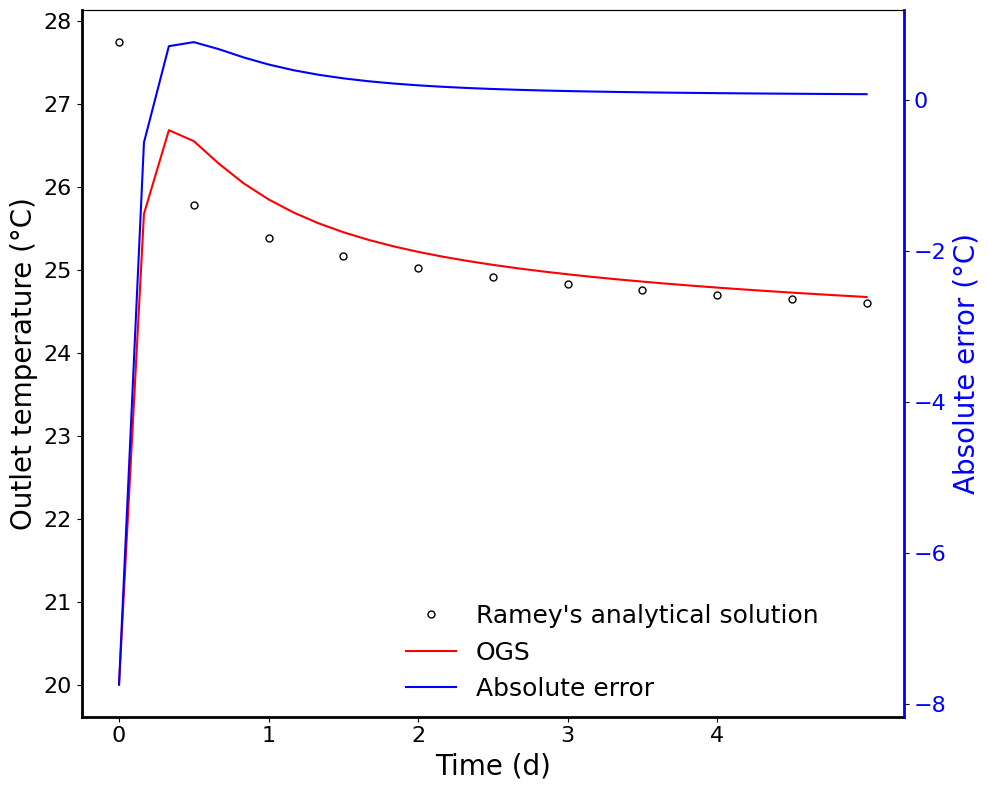

In [17]:
# Plot numerical vs. analytical result
fig, ax1 = plt.subplots(figsize=(10, 8))

x_pos = np.arange(0, 432000, 60 * 60 * 24)
x_ticks = np.arange(0, 5, 1)


ax1.plot(
    time_range,
    data.iloc[-1, :],
    "k.",
    markersize=10,
    markerfacecolor="none",
    label="Ramey's analytical solution",
)
ax1.plot(time, temperature_BHE1_tube, "r", label="OGS")
ax1.set_ylabel("Outlet temperature (°C)", fontsize=20)
ax1.set_xlabel("Time (d)", fontsize=20)
ax1.set_xticks(x_pos, x_ticks)
ax1.spines["left"].set_linewidth(2)
ax1.spines["bottom"].set_linewidth(2)
ax1.tick_params(axis="both", labelsize=16)

color = "blue"
ax2 = ax1.twinx()
ax2.plot(time, temperature_BHE1_tube - T_0, color=color, label="Absolute error")
ax2.set_ylabel("Absolute error (°C)", color=color, fontsize=20)
ax2.tick_params(axis="y", labelcolor=color)
ax2.spines["right"].set_color("blue")
ax2.spines["right"].set_linewidth(2)
ax2.tick_params(axis="y", labelsize=16)

plt.figlegend(fontsize=18, loc=(0.4, 0.1), frameon=False)
fig.tight_layout()

plt.show()

Figure 2: Comparison with analytical solution results

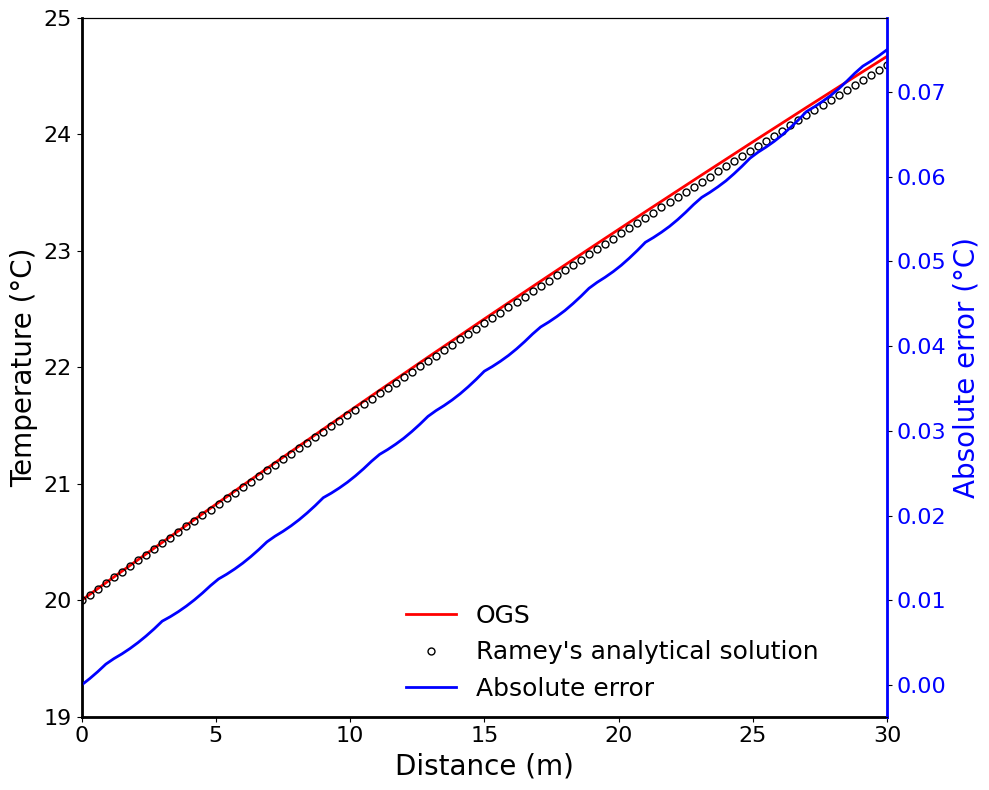

In [18]:
# Extract values along a line in the domain

# Space axis for plotting
length = np.linspace(0, -30, 101)

# Draws a line through the domain for sampling results
x_axis = [(0, 10, i) for i in length]

# At timestep i
i = -1
temp = ms.probe(x_axis, bhe_temp, interp_method="linear")[i]
# Plot
fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.set_xlabel("Distance (m)", fontsize=20)
ax1.set_ylabel("Temperature (°C)", fontsize=20)
ax1.plot(np.linspace(0, 30, 101), temp, "r", linewidth=2, label="OGS")
ax1.plot(
    Z,
    data.iloc[:, -1],
    "k.",
    markersize=10,
    markerfacecolor="none",
    label="Ramey's analytical solution",
)
ax1.set_ylim(19, 25)
ax1.set_xlim(0, 30)
ax1.spines["left"].set_linewidth(2)
ax1.spines["bottom"].set_linewidth(2)
ax1.tick_params(axis="both", labelsize=16)

color = "blue"
ax2 = ax1.twinx()
ax2.set_ylabel("Absolute error (°C)", color=color, fontsize=20)
ax2.plot(
    np.linspace(0, 30, 101),
    temp - data.iloc[:, -1],
    linewidth=2,
    color=color,
    label="Absolute error",
)
ax2.tick_params(axis="y", labelcolor=color)
ax2.spines["right"].set_color("blue")
ax2.spines["right"].set_linewidth(2)
ax2.tick_params(axis="y", labelsize=16)

fig.tight_layout()
plt.figlegend(fontsize=18, loc=(0.4, 0.1), frameon=False)
plt.show()

max_error = 0.08
if np.max(np.abs(temp - data.iloc[:, -1])) > max_error:
    msg = f"The maximum temperature error is over {max_error} °C, which is higher than expected"
    raise RuntimeError(msg)

Figure 3: Distributed temperature of fluid and absolute error.

## References

<!-- vale off -->

[1] Ramey Jr, H. J. (1962). Wellbore heat transmission. Journal of petroleum Technology, 14(04), 427-435.

[2] Diersch, H-JG, et al. (2011). "Finite element modeling of borehole heat exchanger systems: Part 1. Fundamentals." Computers & Geosciences 37.8, 1122-1135.

[3] Chaofan Chen, Wanlong Cai, Dmitri Naumov, Kun Tu, Hongwei Zhou, Yuping Zhang, Olaf Kolditz, Haibing Shao (2021). Numerical investigation on the capacity and efficiency of a deep enhanced U-tube borehole heat exchanger system for building heating. Renewable Energy, 169, 557-572.

[4] Churchill, S. W. (1977). Comprehensive correlating equations for heat, mass and momentum transfer in fully developed flow in smooth tubes. Industrial & Engineering Chemistry Fundamentals, 16(1), 109-116.

<!-- vale on -->